<a href="https://colab.research.google.com/github/Bibek04-bit/Flood-Forecasting/blob/main/Major_p_initial_flood_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Saving final_flood_features.csv to final_flood_features.csv
User uploaded file "final_flood_features.csv" with length 1548403 bytes


In [ ]:
import pandas as pd

file_name = 'final_flood_features.csv'

try:
    df = pd.read_csv(file_name)
    print(f'Successfully loaded {file_name} into a DataFrame.')
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found. Please ensure it's uploaded and the name is correct.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")


Successfully loaded final_flood_features.csv into a DataFrame.


,Date,Daily flow Rate,Gauge height flow,24h accumulated,sm_top_0_10cm,sm_10_40cm,sm_change_rate,saturation_index,flow_change_rate,flow_lag_1d,...,Elevation,Mean_TWI,Drainage_Density,Mean_CN,LULC_Forest_pct,LULC_Agriculture_pct,LULC_BuiltUp_pct,LULC_Grassland_pct,LULC_Water_pct,LULC_Barren_pct
0,2009-01-03,456.0,3.33,0.0,22.784667,65.749364,4.666667,39.970546,-0.008696,460.0,...,2498.092699,5.534685,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001
1,2009-01-04,448.0,3.31,0.0,22.027667,68.656034,-0.757000,40.679014,-0.017544,456.0,...,2498.092699,5.534685,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001
2,2009-01-05,445.0,3.30,0.0,18.637667,58.216001,-3.390000,34.469000,-0.006696,448.0,...,2498.092699,5.534685,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001
3,2009-01-06,449.0,3.31,0.0,17.945667,56.251036,-0.692000,33.267815,0.008989,445.0,...,2498.092699,5.534685,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001
4,2009-01-07,453.0,3.32,0.0,18.687000,58.913774,0.741334,34.777710,0.008909,449.0,...,2498.092699,5.534685,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001


In [ ]:
import pandas as pd
import numpy as np


In [ ]:
import pandas as pd
import numpy as np

# assume df is your dataframe
# required columns:
# ['GaugeHeight', 'Flow', 'API', 'saturation_index', 'flow_change_rate',
#  'flow_lag_1d', 'flow_lag_2d', 'Date']

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# ---- Percentile-based thresholds ----
GH_alert   = df['Gauge height flow'].quantile(0.90)
GH_warning = df['Gauge height flow'].quantile(0.95)
GH_danger  = df['Gauge height flow'].quantile(0.99)

Q95 = df['Daily flow Rate'].quantile(0.95)
Q99 = df['Daily flow Rate'].quantile(0.99)

API_75 = df['API'].quantile(0.75)
SM_sat_thresh = df['saturation_index'].quantile(0.80)

flow_rise_thresh = df['flow_change_rate'].quantile(0.90)

In [ ]:
def assign_flood_level(row):
    gh = row['Gauge height flow']
    q  = row['Daily flow Rate']

    if gh >= GH_danger and q >= Q99:
        return 3

    elif gh >= GH_warning and q >= Q95 and (
        row['API'] >= API_75 or
        row['saturation_index'] >= SM_sat_thresh
    ):
        return 2

    elif gh >= GH_alert and (
        row['flow_change_rate'] >= flow_rise_thresh or
        row['flow_lag_1d'] >= Q95
    ):
        return 1

    else:
        return 0

df['flood_raw'] = df.apply(assign_flood_level, axis=1)


In [ ]:
df['flood_final'] = df['flood_raw'].copy()

for i in range(1, len(df)-1):
    if df.loc[i, 'flood_raw'] == 0:
        # if surrounded by flood days → mark as flood
        if df.loc[i-1, 'flood_raw'] >= 1 and df.loc[i+1, 'flood_raw'] >= 1:
            df.loc[i, 'flood_final'] = max(
                df.loc[i-1, 'flood_raw'],
                df.loc[i+1, 'flood_raw']
            )


In [ ]:
# remove single-day flood noise
for i in range(len(df)):
    if df.loc[i, 'flood_final'] >= 1:
        if not (
            (i > 0 and df.loc[i-1, 'flood_final'] >= 1) or
            (i < len(df)-1 and df.loc[i+1, 'flood_final'] >= 1)
        ):
            df.loc[i, 'flood_final'] = 0


In [ ]:
display(df[['Date', 'Gauge height flow', 'Daily flow Rate', 'flood_raw', 'flood_final']].head())

,Date,Gauge height flow,Daily flow Rate,flood_raw,flood_final
0,2009-01-03,3.33,456.0,0,0
1,2009-01-04,3.31,448.0,0,0
2,2009-01-05,3.30,445.0,0,0
3,2009-01-06,3.31,449.0,0,0
4,2009-01-07,3.32,453.0,0,0


In [ ]:
display(df['flood_final'].value_counts())

,count
flood_final,
0,5114
2,160
1,148
3,54


### Save to Colab environment

This will save the CSV file directly to your Colab environment. You can see it in the file browser (folder icon on the left sidebar).

In [ ]:
output_file_name = 'df_with_flood_labels.csv'
df.to_csv(output_file_name, index=False)
print(f"DataFrame saved to '{output_file_name}' in your Colab environment.")

DataFrame saved to 'df_with_flood_labels.csv' in your Colab environment.


### Download to your device

This will trigger a download of the CSV file to your local machine.

In [ ]:
from google.colab import files

files.download(output_file_name)
print(f"'{output_file_name}' downloaded to your device.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'df_with_flood_labels.csv' downloaded to your device.


RANDOM FOREST TRAINING

In [ ]:
df = df.sort_values('Date')

df['flood_t1'] = df['flood_final'].shift(-1)
df['flood_t3'] = df['flood_final'].shift(-3)

df = df.dropna().reset_index(drop=True)


In [ ]:
dynamic_forecast_features = [
    '24h accumulated',
    'rain_sum_3d',
    'rain_sum_5d',
    'rain_sum_7d',
    'sm_top_0_10cm',
    'sm_10_40cm',
    'sm_change_rate',
    'saturation_index',
    'API',
    'flow_lag_1d',
    'flow_lag_2d'
]

static_features = [
    'Avg_Slope',
    'Elevation',
    'Mean_TWI',
    'Drainage_Density',
    'Mean_CN',
    'LULC_Forest_pct',
    'LULC_Agriculture_pct',
    'LULC_BuiltUp_pct',
    'LULC_Grassland_pct',
    'LULC_Water_pct',
    'LULC_Barren_pct'
]

features = dynamic_forecast_features + static_features


In [ ]:
train = df[df['Date'] < '2018-01-01']
test  = df[df['Date'] >= '2018-01-01']

X_train = train[features]
X_test  = test[features]

y_train_t1 = train['flood_t1']
y_test_t1  = test['flood_t1']

y_train_t3 = train['flood_t3']
y_test_t3  = test['flood_t3']


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 0.7]
}

grid_t1 = GridSearchCV(
    rf,
    param_grid,
    cv=tscv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_t1.fit(X_train, y_train_t1)
best_rf_t1 = grid_t1.best_estimator_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
grid_t3 = GridSearchCV(
    rf,
    param_grid,
    cv=tscv,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_t3.fit(X_train, y_train_t3)
best_rf_t3 = grid_t3.best_estimator_


In [ ]:
y_pred_t1 = best_rf_t1.predict(X_test)
y_pred_t3 = best_rf_t3.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report

print("t+1 Forecast")
print(classification_report(y_test_t1, y_pred_t1))

print("t+3 Forecast")
print(classification_report(y_test_t3, y_pred_t3))


t+1 Forecast
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      2082
         1.0       0.32      0.32      0.32        41
         2.0       0.45      0.50      0.48        40
         3.0       0.00      0.00      0.00        25

    accuracy                           0.96      2188
   macro avg       0.44      0.45      0.44      2188
weighted avg       0.95      0.96      0.95      2188

t+3 Forecast
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      2082
         1.0       0.00      0.00      0.00        41
         2.0       0.38      0.45      0.41        40
         3.0       0.00      0.00      0.00        25

    accuracy                           0.95      2188
   macro avg       0.34      0.36      0.35      2188
weighted avg       0.93      0.95      0.94      2188



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score

def flood_metrics(y_true, y_pred):
    y_true_bin = (y_true >= 1).astype(int)
    y_pred_bin = (y_pred >= 1).astype(int)

    POD = recall_score(y_true_bin, y_pred_bin)
    FAR = 1 - precision_score(y_true_bin, y_pred_bin)
    CSI = f1_score(y_true_bin, y_pred_bin)

    return POD, FAR, CSI

POD1, FAR1, CSI1 = flood_metrics(y_test_t1, y_pred_t1)
POD3, FAR3, CSI3 = flood_metrics(y_test_t3, y_pred_t3)

print(f"t+1 → POD:{POD1:.2f}, FAR:{FAR1:.2f}, CSI:{CSI1:.2f}")
print(f"t+3 → POD:{POD3:.2f}, FAR:{FAR3:.2f}, CSI:{CSI3:.2f}")


t+1 → POD:0.58, FAR:0.27, CSI:0.65
t+3 → POD:0.35, FAR:0.35, CSI:0.45


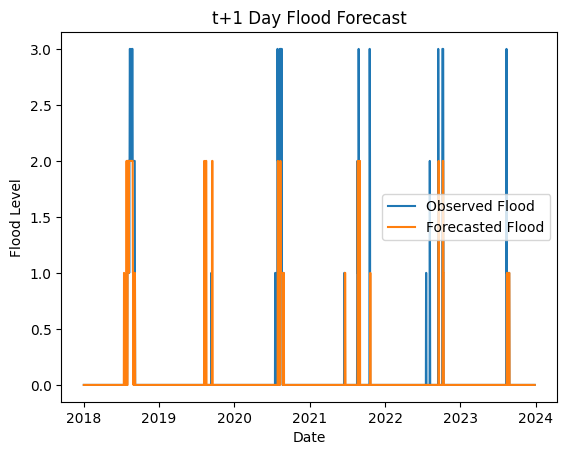

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(test['Date'], y_test_t1.values, label='Observed Flood')
plt.plot(test['Date'], y_pred_t1, label='Forecasted Flood')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Flood Level")
plt.title("t+1 Day Flood Forecast")
plt.show()


In [ ]:
import pandas as pd

importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf_t1.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance.head(10))


             Feature  Importance
9        flow_lag_1d    0.292949
10       flow_lag_2d    0.215577
8                API    0.133334
6     sm_change_rate    0.077982
4      sm_top_0_10cm    0.075669
5         sm_10_40cm    0.072766
7   saturation_index    0.063178
3        rain_sum_7d    0.030785
1        rain_sum_3d    0.016604
2        rain_sum_5d    0.014559


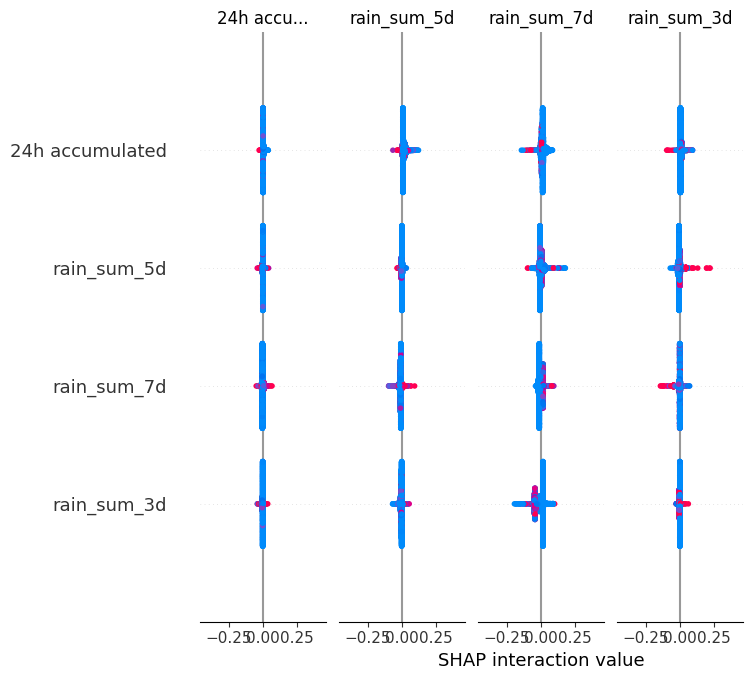

In [ ]:
import shap

explainer = shap.TreeExplainer(best_rf_t1)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


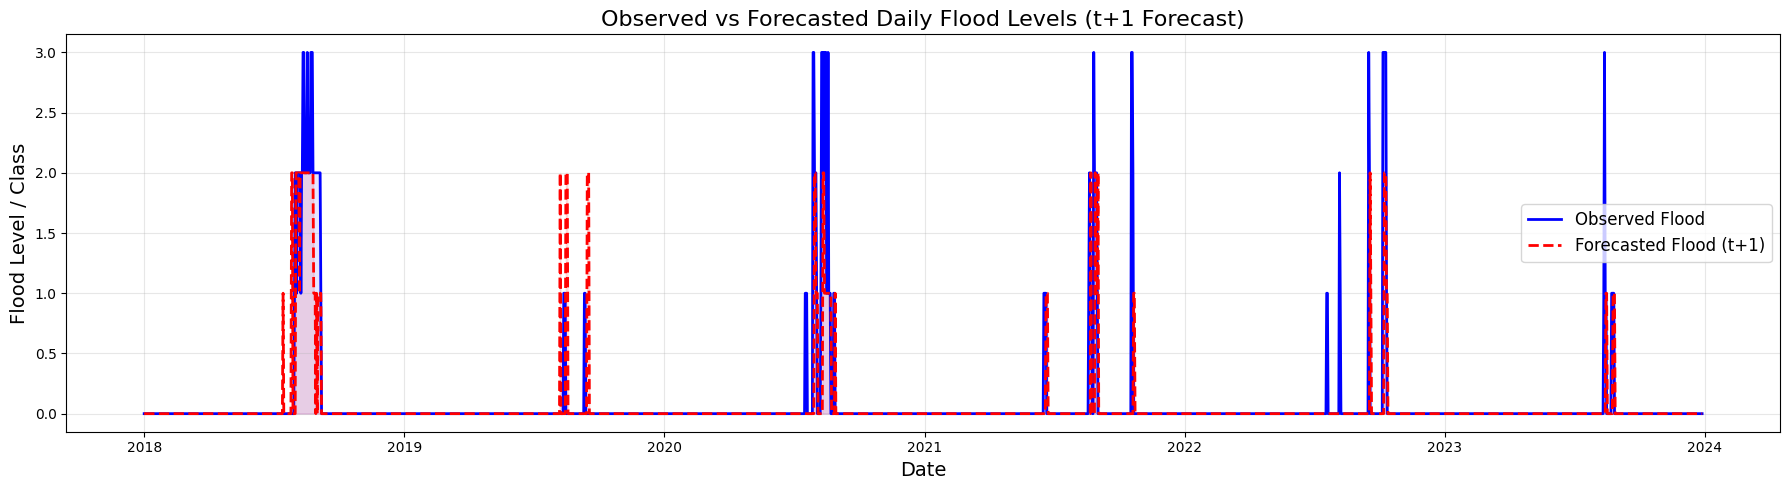

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have:
# test['Date'] → datetime of test period
# y_test_t1 → actual flood labels (observed)
# y_pred_t1 → predicted flood labels (forecasted)

plt.figure(figsize=(18,5))

# Plot observed floods
plt.plot(test['Date'], y_test_t1.values, label='Observed Flood', color='blue', linewidth=2)

# Plot forecasted floods
plt.plot(test['Date'], y_pred_t1, label='Forecasted Flood (t+1)', color='red', linestyle='--', linewidth=2)

# Optional: fill areas to highlight flood events
plt.fill_between(test['Date'], 0, y_test_t1.values, color='blue', alpha=0.1)
plt.fill_between(test['Date'], 0, y_pred_t1, color='red', alpha=0.1)

# Labels and title
plt.xlabel("Date", fontsize=14)
plt.ylabel("Flood Level / Class", fontsize=14)
plt.title("Observed vs Forecasted Daily Flood Levels (t+1 Forecast)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Create SHAP explainer
explainer = shap.TreeExplainer(best_rf_t1)
shap_values = explainer.shap_values(X_train)

# Compute mean absolute SHAP for feature importance
mean_abs_shap = pd.DataFrame({
    'Feature': X_train.columns,
    'MeanAbsSHAP': np.mean(np.abs(shap_values), axis=0)
}).sort_values(by='MeanAbsSHAP', ascending=False)

# Keep top 15 features for clarity
top_features = mean_abs_shap['Feature'].head(15).tolist()

# Subset SHAP values and X_train
shap_values_top = shap_values[:, :len(top_features)]  # only top features
X_train_top = X_train[top_features]

# Bar-style SHAP plot (clean, thesis-ready)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_top, X_train_top, plot_type='bar', show=True)


ValueError: Per-column arrays must each be 1-dimensional